# PSF metacal validation/unit test

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tqdm
import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf
import galflow as gf
import galsim
import ngmix

from multiprocessing import Pool, freeze_support, cpu_count

2022-06-07 02:42:24.006234: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 02:42:24.006252: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-07 02:42:26.062133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-07 02:42:26.062151: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-07 02:42:26.062164: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dappcm89.extra.cea.fr): /proc/driver/nvidia/version does not exist
2022-06-07 02:42:26.062364: I tensorflow/core/platform/

In [3]:
#global values
fixnoise = True
batch_size=100
scale= .2
stamp_size = 51
rng = np.random.RandomState(31415)
real_shear = [0.01,0.0]
noise_level = 1e-5

In [4]:
#dataset
data= tfds.load('simple/small_100k_noshear')
data = data['train'].cache()
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
labels = onebatch['label'] 

In [6]:
#create 1 batch of observed images
psf_fwhm = 0.7
psf = galsim.Moffat(beta=5.0, fwhm=psf_fwhm).shear(g1=.0,g2=0.)
psf_image = tf.convert_to_tensor(psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array)[tf.newaxis]
psf_images = tf.repeat(psf_image,batch_size,axis=0)



gal_images=amc.noiseless_real_mcal_image(onebatch['gal_model'],
                                         psf_images,
                                         tf.repeat([real_shear],
                                        len(batch_size),axis=0))

noise = random.normal(scale=noise_level,size=[batch_size,51,51])
gal_images += noise
noise_psf = random.normal(scale=noise_level,size=[batch_size,51,51])/1000
psf_images = psf_images



2022-06-07 02:42:27.863946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 02:42:27.863963: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


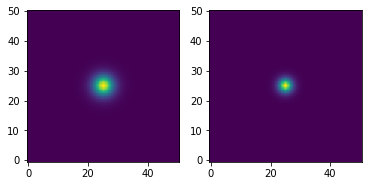

In [7]:
subplot(121)
imshow(gal_images[0], origin='lower')
subplot(122)
imshow(psf_images[0], origin='lower')

In [8]:
#set up jacobian
jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)
psf_jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)

In [9]:
T_range = [-1.0, 5.]

F_range = [-1, 10.]

g_prior = ngmix.priors.GPriorBA(sigma=0.1, rng=rng)
cen_prior = ngmix.priors.CenPrior(
    cen1=0, cen2=0, sigma1=scale, sigma2=scale, rng=rng,
)
T_prior = ngmix.priors.FlatPrior(minval=T_range[0], maxval=T_range[1], rng=rng)
F_prior = ngmix.priors.FlatPrior(minval=F_range[0], maxval=F_range[1], rng=rng)

nband =1
F_prior = [F_prior]*nband

prior = ngmix.joint_prior.PriorSimpleSep(
    cen_prior=cen_prior,
    g_prior=g_prior,
    T_prior=T_prior,
    F_prior=F_prior,
)



In [10]:
#LM fitter
fitter = ngmix.fitting.Fitter(model='exp', prior=prior)
# make parameter guesses based on a psf flux and a rough T
guesser = ngmix.guessers.TPSFFluxAndPriorGuesser(
    rng=rng,
    T=0.25,
    prior=prior,
)

# psf fitting with coelliptical gaussians
psf_ngauss = 5
psf_fitter = ngmix.fitting.CoellipFitter(ngauss=psf_ngauss)
# special guesser for coelliptical gaussians
psf_guesser = ngmix.guessers.CoellipPSFGuesser(rng=rng, ngauss=psf_ngauss)

# this runs the fitter. We set ntry=2 to retry the fit if it fails
psf_runner = ngmix.runners.PSFRunner(
    fitter=psf_fitter, guesser=psf_guesser,
    ntry=20,
)
runner = ngmix.runners.Runner(
    fitter=fitter, guesser=guesser,
    ntry=5,
)

# this bootstraps the process, first fitting psfs then the object
boot = ngmix.bootstrap.Bootstrapper(
    runner=runner,
    psf_runner=psf_runner,
)


# this "bootstrapper" runs the metacal image shearing as well as both 
# psf and object measurements

METACAL_TYPES = ['noshear',
                 '1p','1m','2p','2m',
                 '1p_psf','1m_psf','2p_psf','2m_psf']
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='dilate',
  types=METACAL_TYPES,
  fixnoise=fixnoise,
)

In [11]:
im = gal_images[0].numpy()
psf_im = psf_images[0].numpy() 
wt = tf.reduce_mean(1.0/(noise)**2,axis=0)
psf_wt = tf.reduce_mean(1.0/(noise_psf)**2,axis=0)

psf_obs = ngmix.Observation(
  psf_im,
  weight=psf_wt,
  jacobian=psf_jacobian,
)
obs = ngmix.Observation(
  im,
  jacobian=jacobian,
  weight=wt,
  psf=psf_obs,
)

In [12]:
resdict, obsdict = boot.go(obs)

In [13]:
def get_metacal_response_ngmix(resdict):
  step=0.01

  #shear
  g0s = np.array([resdict['noshear']['g'][0], resdict['noshear']['g'][1]])
  g1p = np.array([resdict['1p']['g'][0], resdict['1p']['g'][1]])
  g1m = np.array([resdict['1m']['g'][0], resdict['1m']['g'][1]])
  g2p = np.array([resdict['2p']['g'][0], resdict['2p']['g'][1]])
  g2m = np.array([resdict['2m']['g'][0], resdict['2m']['g'][1]])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  #PSF
  g1p_psf = np.array([resdict['1p_psf']['g'][0], resdict['1p_psf']['g'][1]])
  g1m_psf = np.array([resdict['1m_psf']['g'][0], resdict['1m_psf']['g'][1]])
  g2p_psf = np.array([resdict['2p_psf']['g'][0], resdict['2p_psf']['g'][1]])
  g2m_psf = np.array([resdict['2m_psf']['g'][0], resdict['2m_psf']['g'][1]])    
  
  R11_psf = (g1p_psf[0]-g1m_psf[0])/(2*step)
  R21_psf = (g1p_psf[1]-g1m_psf[1])/(2*step) 
  R12_psf = (g2p_psf[0]-g2m_psf[0])/(2*step)
  R22_psf = (g2p_psf[1]-g2m_psf[1])/(2*step)  
  
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,
    '1p_psf':g1p_psf,
    '1m_psf':g1m_psf,
    '2p_psf':g2p_psf,
    '2m_psf':g2m_psf,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  Rpsf = np.array(
    [[R11_psf,R12_psf],
     [R21_psf,R22_psf]])
    
  return ellip_dict, R, Rpsf

In [14]:
ellips, R, Rpsf = get_metacal_response_ngmix(resdict)

In [15]:
linalg.inv(R) @ ellips['noshear']

array([0.00220468, 0.00749968])

In [16]:
ellips_list =[]
R_list =[]
Rpsf_list =[]
fail_list = []
for i in tqdm.tqdm(range(len(gal_images))):
    im = gal_images[0].numpy()
    psf_im = psf_images[0].numpy() 
    
    wt = tf.reduce_mean(1.0/(noise)**2,axis=0)
    psf_wt = tf.reduce_mean(1.0/(noise_psf)**2,axis=0)
    
    psf_obs = ngmix.Observation(
      psf_im,
      weight=psf_wt,
      jacobian=psf_jacobian,
    )
    
    obs = ngmix.Observation(
      im,
      jacobian=jacobian,
      weight=wt,
      psf=psf_obs,
    )
    try:
        resdict, _ = boot.go(obs)
        
        ellips, R, Rpsf = get_metacal_response_ngmix(resdict)

        ellips_list +=[ellips]
        R_list +=[R]
        Rpsf_list +=[Rpsf]
        fail_list += [f"{i} passed"]
        #print(fail_list, end="\r")
    except:
        fail_list += [f"{i} failed"]
        #print(fail_list, end="\r")

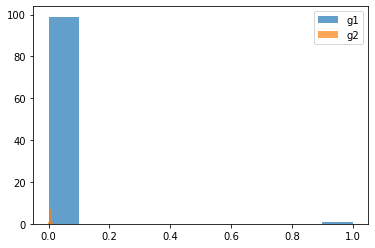

In [17]:
noshear_array = array([ellips['noshear'] for ellips in ellips_list])
hist(noshear_array[:,0],alpha=.7,label='g1')
hist(noshear_array[:,1],alpha=.7,label='g2')
legend()

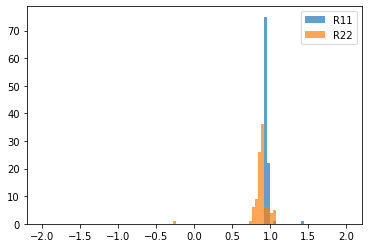

In [21]:
R_array = array([R for R in R_list])
hist(R_array[:,0,0],alpha=.7,label='R11',bins=100,range=[-2,2])
hist(R_array[:,1,1],alpha=.7,label='R22',bins=100,range=[-2,2])
legend()

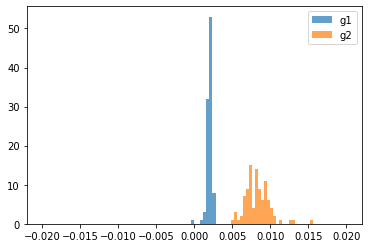

In [31]:
corr_g = array([linalg.inv(R) @ noshear for R, noshear in zip(R_array,noshear_array)])
hist(corr_g[:,0],bins=100,range=[-.02,.02],alpha=0.7,label='g1');
hist(corr_g[:,1],bins=100,range=[-.02,.02],alpha=0.7,label='g2');
legend()

In [35]:
R

array([[0.95096868, 0.01930824],
       [0.332209  , 0.86168684]])